In [6]:
import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

rhou
1.2383331 0.76608366 0.47224945
(64, 64)


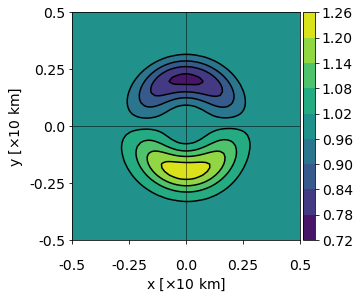

In [18]:
swe = False

attribute = 'p2_nodes'
attribute = 'rhou'
et = 10.0
print(attribute)

base_fn = "output_travelling_vortex"
directory = "output_travelling_vortex"
py_directory = "../%s/Frsq=0.02/" %directory
py_directory = "../%s/" %directory

Nx, Ny = 64, 64
tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)

# base_fn = "output_travelling_vortex"
# directory = "output_travelling_vortex"
# py_directory = "../%s/" %directory

# Nx, Ny = 64, 64
# euler_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)

times = [1.0]
l_typ = 'TIME'
# times = [0]
# l_typ = 'WINDOW_STEP'
# times = [0]
tags = tc.get_tag_dict()
tag = 'ic' if times[0] == 0.0 else tags[9]
# tag = 'full_split_2'
# tag = tags[7]
        
prt = utils.prt_time(debug=False)
attr_labels = pt.labels_increment()

def get_ens(tc, sfx , diff, attribute, swe=True):
#     print(attribute, sfx, times, tag)
    ens = tc.get_ensemble(times, 1, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=True)[1]
    rho = tc.get_ensemble(times, 1, 'rho', sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=True)[1]
    if swe:
        ens = ens[:,0,:]
#     else:
#         ens *= 100.0
    ens = ens.T / rho.T
#     
    label = sfx + '_' + attribute
    return label, ens

diff = False
sfx1 = 'neg_debug'
sfx1 = 'artigen'
sfx1 = 'truth_artigen_ib-0'
sfx1 = 'obs_artigen'
sfx1 = 'truth_ib-0'
# sfx1 = 'truth_p33_ib-0'
# sfx1 = 'obs'
# sfx1 = 'analytical'
sfx1 = 'neg_debug_psinc'
# sfx1 = 'analytical_truth'
# sfx1 = 'comp_imbal_half_mdp_ib-0'
# sfx1 = 'obs_truthgen'

if swe:
    l1, a1 = get_ens(tc, sfx1, diff, attribute,swe=True)
    la = 'SWE_vortex'
    aa = a1
    lvls = np.arange(-0.0155,0.0065,0.0015) * 10.0
else:
    l2, a1 = get_ens(tc, sfx1, diff, 'rho', swe=False)
    l2, a2 = get_ens(tc, sfx1, diff, attribute, swe=False)
    la = 'Euler vortex'
#     if attribute == 'rhoY':
#         aa = a2 / a1
#     else:
#         aa = a2
    aa = a2
#     aa -= 1.0
    print(aa.max(), aa.min(), aa.max() - aa.min())
    lvls = np.arange(-0.0065,0.0025,0.0005) * 10.0
    
print(aa.shape)
if sfx1 == 'artigen' or sfx1=='psinc':
    np.save('ic_%s_%s.npy' %(attribute,sfx1), aa.T)
ll = [aa, '']
pl_lst = [ll]

pl = pt.plotter(pl_lst,ncols=1,figsize=(10,5),sharey=False)
x_axs = [-0.5,-0.25,0.0,0.25,0.5]
y_axs = [-0.5,-0.25,0.0,0.25,0.5]
x_loc = np.linspace(0,Nx-1,5)
y_loc = np.linspace(0,Ny-1,5)
if swe: 
    x_label = r'x [km]'
    y_label = r'y [km]'
else:
    x_label = r'x [$\times 10$ km]'
    y_label = r'y [$\times 10$ km]'

axvline = 31.5
axhline = 31.5

pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label, axhline=axhline, axvline=axvline)
_ = pl.plot(aspect='equal',method='contour')

lbl = 'swe' if swe else 'euler'
# pl.save_fig('./output/euler_imprint')

Generate analytical solution from 0.0 to 100s.

In [206]:
from scipy.interpolate import griddata
import h5py
from tqdm import tqdm

In [219]:
Nx, Ny = 200, 200
et = 3.0
tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
sfx1 = 'analytical_truth'

debug = False

def get_pts(Ngrid):
    x =np.linspace(0,1,Ngrid)
    xg, yg = np.meshgrid(x,x)
    points = np.array([point for point in zip(xg.flatten(),yg.flatten())])
    return points
    
def new_grid(ng):
    xn = np.linspace(0,1,ng)
    xng, yng = np.meshgrid(xn,xn)
    return xng, yng

attributes = ['rho', 'rhou', 'rhov', 'rhoX', 'rhoY', 'p2_nodes']
shfts = np.arange(0,201,1)

times = [0.0]
et = 1.0
tts = np.arange(0.0,et+0.005,0.005)
sfx = 'truthgen_new'

file = h5py.File('output_travelling_vortex_ensemble=1_64_64_%.1f_%s.h5' %(et,sfx), 'w')
for t_idx in tqdm(range(len(shfts))):
    shift = shfts[t_idx]
    pl_lst = []
    
    for attribute in attributes:
        Ngrid = Nx if attribute is not 'p2_nodes' else Nx+1
        ngp = 64 if attribute is not 'p2_nodes' else 65

        analytical = get_ens(tc, sfx1, diff, attribute, swe=False)[1].T

        if attribute == 'p2_nodes':
            points = get_pts(Ngrid)
            values = analytical.ravel()
            ng = new_grid(Nx)
            analytical = griddata(points, values, ng, method='cubic')

        shifted = np.roll(analytical, shift, axis=0)
        shifted = np.roll(shifted, shift, axis=1)

        points = get_pts(Nx)
        values = shifted.ravel()
        ng = new_grid(ngp)
        shifted = griddata(points, values, ng, method='cubic')
        shifted = np.pad(shifted, (2,2), mode='wrap')

        pl_lst.append([shifted, attribute])
        tt = tts[t_idx]
        
        substep = 'ic' if t_idx == 0 else 'after_full_step'
        file.create_dataset('%s/%s_ensemble_mem=0_%.3f_%s' %(attribute, attribute, tt, substep), data=shifted)
    
    if debug:
        pl = pt.plotter(pl_lst,ncols=3,figsize=(15,10),sharey=False)
        x_axs = [-0.5,-0.25,0.0,0.25,0.5]
        y_axs = [-0.5,-0.25,0.0,0.25,0.5]
        
        ngp_pg = ngp+4
        x_loc = np.linspace(0,ngp_pg-1,5)
        y_loc = np.linspace(0,ngp_pg-1,5)

        x_label = r'x [$\times 10$ km]'
        y_label = r'y [$\times 10$ km]'

        axvline = int(ngp_pg / 2.0) - 0.5
        axhline = int(ngp_pg / 2.0) - 0.5

        pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label, axhline=axhline, axvline=axvline)
        _ = pl.plot(aspect='equal',method='contour')
        
file.close()

100%|██████████| 201/201 [15:00<00:00,  4.48s/it]


We extend the analytical solution generated above to however long we like.

In [229]:
filename = './output_travelling_vortex_ensemble=1_64_64_1.0_truthgen_new.h5'
file = h5py.File(filename, 'r')

new_et = 10.0
newf = h5py.File('output_travelling_vortex_ensemble=1_64_64_' + str(new_et) + '_truthgen.h5', 'w')

gen_times = np.arange(0.0,1.005,0.005)
attributes = ['rho', 'rhou', 'rhov', 'rhoX', 'rhoY', 'p2_nodes']

Nloops = int(new_et)

for attribute in tqdm(attributes):
    first_step = True
    for t_idx, t in enumerate(gen_times[:-1]):
        substep = 'ic' if t_idx == 0 else 'after_full_step'
        ds_name = '%s_ensemble_mem=0_%.3f_%s' %(attribute, t, substep)
        data = file[attribute][ds_name]
        
        NNloops = Nloops+1 if t_idx == 0 else Nloops
        for N in range(NNloops):
            substep = 'ic' if first_step else 'after_full_step'
            first_step = False
            
            newt = t % 1
            newt += N
#             print(attribute, newt, substep)
            newf.create_dataset('%s/%s_ensemble_mem=0_%.3f_%s' %(attribute, attribute, newt, substep), data=data)
        
file.close()
newf.close()

100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


In [267]:
bigPa = 0.17
smallPa = 6.7*1e-6

sd_rho = 0.025
sd_rhou = 0.0325
sd_rhov = 0.0325
sd_rhoY = 0.00025
sd_pi = 0.0004
bigs = np.array([sd_rho, sd_rhou, sd_rhov, sd_rhoY, sd_pi])*2.0

smalls = np.array([0.00039, 0.000549, 0.000548, 1.9333e-08, 2.373795e-07])

def get_log_midpt(small,big):
    logbig = np.log(big)
    logsmall = np.log(small)
    logmid = 0.5 * (logbig + logsmall)
    mid = np.exp(logmid)
    return mid

mids = []

for small, big in zip(smalls,bigs):
    mid = get_log_midpt(small,big)
    mids.append(mid)
    
# logbigPa = np.log(bigPa)
# logsmallPa = np.log(smallPa)
# logmidPa = 0.5 * (logbigPa + logsmallPa)
# midPa = get_log_midpt(smallPa,bigPa)
print(bigs)
print(mids)
print(smalls)

h_ref = 10000.0
t_ref = 100.0
T_ref = 300.0
R_gas = 287.4
p_ref = 1e5
rho_ref = p_ref / (R_gas * T_ref)
u_ref = h_ref / t_ref

### dimension calculator
def dimensionaliser(vars):
    dims = []
    for idx, var in enumerate(vars):
        if idx == 0:
            dims.append(var * rho_ref)
        if idx == 1 or idx == 2:
            dims.append(var * rho_ref * u_ref)
        if idx == 3:
            dims.append(var * rho_ref * T_ref)
        if idx == 4:
            dims.append(var)

    return dims
bigs_dim = dimensionaliser(bigs)
smalls_dim = dimensionaliser(smalls)
mids_dim = dimensionaliser(mids)
print("\nbigs_dims:")
print(bigs_dim)
print("\nmids_dims:")
print(mids_dim)
print("\nsmall_dims:")
print(smalls_dim)

[0.05   0.065  0.065  0.0005 0.0008]
[0.004415880433163922, 0.005973692325521966, 0.005968249324550707, 3.1090995481007025e-06, 1.3780551512911225e-05]
[3.900000e-04 5.490000e-04 5.480000e-04 1.933300e-08 2.373795e-07]

bigs_dims:
[0.05799118533982835, 7.538854094177686, 7.538854094177686, 0.17397355601948505, 0.0008]

mids_dims:
[0.005121642812762609, 0.6928429976249091, 0.6922117054686507, 0.0010818022088033064, 1.3780551512911225e-05]

small_dims:
[0.0004523312456506611, 0.06367432150313151, 0.06355833913245186, 6.726861517049408e-06, 2.373795e-07]


In [259]:
A = np.log(1.2345)
B = np.exp(A)
print(A,B)

0.2106660298030971 1.2345
